# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 29, 11:59PM

### Name: Harsh Sanjay Agrawal


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
from keras.datasets import cifar10
import numpy as np

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

170508288/170498071 [==============================] - 4s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    result = np.zeros((y.shape[0],10))
    for i in range(len(y)):
        result[i][y[i]] = 1
    return result

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [3]:
myarr = np.arange(50000)
np.random.shuffle(myarr)
train_index = myarr[0:40000]
validation_index = myarr[40000:50000]


x_tr = x_train[train_index, :]
y_tr = y_train_vec[train_index, :]
x_val = x_train[validation_index, :]
y_val = y_train_vec[validation_index, :]


print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [4]:
"""
Colvolution 3@32x32
max-pool 32@30x30
convolution 32@15x15
max-pool 64@12x12
dense 64@6x6
1x256
1x10

Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax
"""

# Build the model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='valid', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (4, 4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 12, 12, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [5]:
# Define model optimizer and loss function
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2)

train_datagen.fit(x_tr)
train_generator = train_datagen.flow(x_tr, y_tr, batch_size=64)
test_generator = ImageDataGenerator().flow(x_val, y_val, batch_size=64)

learning_rate = 0.001 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [6]:
# Train the model and store model parameters/loss values
history = model.fit(train_generator, epochs=25, validation_data=test_generator)

Epoch 1/25
625/625 [==============================] - 93s 147ms/step - loss: 3.4929 - acc: 0.1469 - val_loss: 2.0797 - val_acc: 0.2360
Epoch 2/25
625/625 [==============================] - 87s 139ms/step - loss: 2.0455 - acc: 0.2660 - val_loss: 2.1407 - val_acc: 0.2674
Epoch 3/25
625/625 [==============================] - 86s 137ms/step - loss: 1.7899 - acc: 0.3576 - val_loss: 1.6352 - val_acc: 0.4092
Epoch 4/25
625/625 [==============================] - 86s 137ms/step - loss: 1.6943 - acc: 0.3947 - val_loss: 1.8097 - val_acc: 0.3648
Epoch 5/25
625/625 [==============================] - 85s 135ms/step - loss: 1.6243 - acc: 0.4245 - val_loss: 1.5221 - val_acc: 0.4687
Epoch 6/25
625/625 [==============================] - 84s 135ms/step - loss: 1.5768 - acc: 0.4487 - val_loss: 1.3806 - val_acc: 0.5099
Epoch 7/25
625/625 [==============================] - 85s 135ms/step - loss: 1.5466 - acc: 0.4608 - val_loss: 1.4772 - val_acc: 0.4653
Epoch 8/25
625/625 [==============================] - 8

## 3. Plot the training and validation loss curve versus epochs. (5 points)

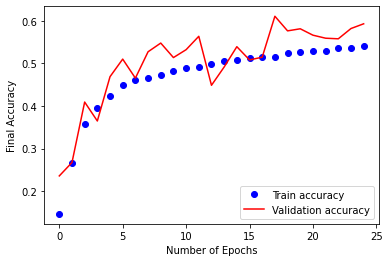

In [7]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Final Accuracy')
plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [8]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
# Define model optimizer and loss function
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.3,
    zoom_range=0.1,
    horizontal_flip=True)

train_datagen.fit(x_train)
train_generator = train_datagen.flow(x_train, y_train_vec, batch_size=64)
test_generator = ImageDataGenerator().flow(x_val, y_val, batch_size=64)

learning_rate = 0.001 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [9]:
#<Train your model on the entire training set (50K samples)>
history = model.fit(train_generator, epochs=25, validation_data=test_generator)

Epoch 1/25
782/782 [==============================] - 106s 135ms/step - loss: 1.2732 - acc: 0.5697 - val_loss: 1.2479 - val_acc: 0.5789
Epoch 2/25
782/782 [==============================] - 104s 133ms/step - loss: 1.2481 - acc: 0.5787 - val_loss: 1.2464 - val_acc: 0.5936
Epoch 3/25
782/782 [==============================] - 104s 133ms/step - loss: 1.2308 - acc: 0.5846 - val_loss: 1.1293 - val_acc: 0.6275
Epoch 4/25
782/782 [==============================] - 105s 134ms/step - loss: 1.2225 - acc: 0.5866 - val_loss: 1.3774 - val_acc: 0.5497
Epoch 5/25
782/782 [==============================] - 105s 134ms/step - loss: 1.2228 - acc: 0.5884 - val_loss: 1.0343 - val_acc: 0.6565
Epoch 6/25
782/782 [==============================] - 104s 133ms/step - loss: 1.2118 - acc: 0.5915 - val_loss: 1.1597 - val_acc: 0.6334
Epoch 7/25
782/782 [==============================] - 105s 134ms/step - loss: 1.2136 - acc: 0.5910 - val_loss: 1.0849 - val_acc: 0.6358
Epoch 8/25
782/782 [============================

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
# Evaluate your model performance (teloss_and_acc = model.evaluate(x_test, y_test_vec)
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('The loss of the model is ' + str(loss_and_acc[0]))
print('The accuracy if the model is ' + str(loss_and_acc[1]))

313/313 [==============================] - 5s 17ms/step - loss: 1.1183 - acc: 0.6175
The loss of the model is 1.1183332204818726
The accuracy if the model is 0.6175000071525574


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


782/782 [==============================] - 368s 468ms/step - loss: 1.4259 - acc: 0.4942 - val_loss: 1.2064 - val_acc: 0.5791
Epoch 2/25
782/782 [==============================] - 366s 468ms/step - loss: 1.0519 - acc: 0.6284 - val_loss: 1.0926 - val_acc: 0.6285
Epoch 3/25
782/782 [==============================] - 366s 468ms/step - loss: 0.9321 - acc: 0.6711 - val_loss: 0.9224 - val_acc: 0.6834
Epoch 4/25
782/782 [==============================] - 367s 469ms/step - loss: 0.8596 - acc: 0.6993 - val_loss: 1.3913 - val_acc: 0.5798
Epoch 5/25
782/782 [==============================] - 368s 470ms/step - loss: 0.8074 - acc: 0.7170 - val_loss: 1.3357 - val_acc: 0.6331
Epoch 6/25
782/782 [==============================] - 365s 467ms/step - loss: 0.7776 - acc: 0.7312 - val_loss: 1.0176 - val_acc: 0.6949
Epoch 7/25
782/782 [==============================] - 366s 469ms/step - loss: 0.7478 - acc: 0.7411 - val_loss: 0.7130 - val_acc: 0.7680
Epoch 8/25
782/782 [==============================] - 364s 

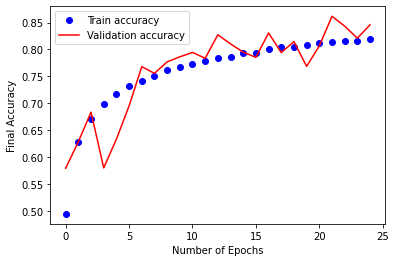

In [11]:
from keras.layers import BatchNormalization, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

history = model.fit(train_generator, epochs=25, validation_data=test_generator)


loss_and_acc = model.evaluate(x_test, y_test_vec)
print('The loss of the model is ' + str(loss_and_acc[0]))
print('The accuracy if the model is ' + str(loss_and_acc[1]))

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Final Accuracy')
plt.legend()
plt.show()

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


782/782 [==============================] - 479s 610ms/step - loss: 1.4045 - acc: 0.4999 - val_loss: 1.5498 - val_acc: 0.5011
Epoch 2/25
782/782 [==============================] - 473s 605ms/step - loss: 1.0065 - acc: 0.6421 - val_loss: 1.3696 - val_acc: 0.5872
Epoch 3/25
782/782 [==============================] - 472s 604ms/step - loss: 0.8630 - acc: 0.6974 - val_loss: 0.7926 - val_acc: 0.7353
Epoch 4/25
782/782 [==============================] - 472s 604ms/step - loss: 0.7862 - acc: 0.7264 - val_loss: 1.1165 - val_acc: 0.6732
Epoch 5/25
782/782 [==============================] - 471s 603ms/step - loss: 0.7245 - acc: 0.7488 - val_loss: 0.9328 - val_acc: 0.6987
Epoch 6/25
782/782 [==============================] - 474s 605ms/step - loss: 0.6831 - acc: 0.7647 - val_loss: 0.9064 - val_acc: 0.7458
Epoch 7/25
782/782 [==============================] - 469s 600ms/step - loss: 0.6433 - acc: 0.7808 - val_loss: 0.8323 - val_acc: 0.7458
Epoch 8/25
782/782 [==============================] - 468s 

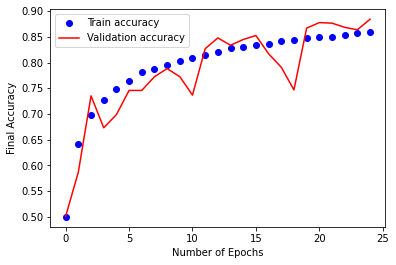

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

history = model.fit(train_generator, epochs=25, validation_data=test_generator)


loss_and_acc = model.evaluate(x_test, y_test_vec)
print('The loss of the model is ' + str(loss_and_acc[0]))
print('The accuracy if the model is ' + str(loss_and_acc[1]))

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Final Accuracy')
plt.legend()
plt.show()